# Practice Session 3: Facial Expressions and Emotion Perception

Authors:

    - Luca Franceschi (u199149)
    - Telmo Linacisoro (u198711)

# Facial Expressions and Emotion Perception
In this notebook we analyze how different are radom annotations from the ones we got as a result of comparing images by similarity to prove that human made annotations provide some genuine insight. We will extract principal components using MDS and reconstruct the circumplex model of affect from it.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.patches as patches

In [2]:
pathToSimScores = './simScores.mat'
pathToImages = 'group_2/'

size = 24

In [3]:
def load_image_names(path):
    names_raw = os.listdir(path)
    return [name.split('.')[0] for name in names_raw]

In [4]:
def load_similarity_scores(path):
    simScores = scipy.io.loadmat(path)['simScores'][0][0]
    return np.array(simScores[0]), np.array(simScores[1])

In [5]:
def display_matrix(matrix, title='Matrix', labels=None):
    plt.imshow(matrix)
    if labels != None:
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [6]:
def display_similarity_consistency_matrices(simMat, consMat, labels):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axs = axs.flatten()
    axs[0].imshow(simMat)
    axs[0].set_title('Similarity Matrix')
    axs[0].set_xticks(range(len(labels)), labels, rotation=90)
    axs[0].set_yticks(range(len(labels)), labels)
    im = axs[1].imshow(consMat)
    axs[1].set_title('Consistency Matrix')
    axs[1].set_xticks(range(len(labels)), labels, rotation=90)
    axs[1].set_yticks([])
    

    cax = fig.add_axes([1, 0.285, 0.03, 0.43])
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()


## Our similarity matrix

In [7]:
simMat, consMat = load_similarity_scores(pathToSimScores)

image_names = load_image_names(pathToImages)

/tmp/ipykernel_5718/3135404283.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


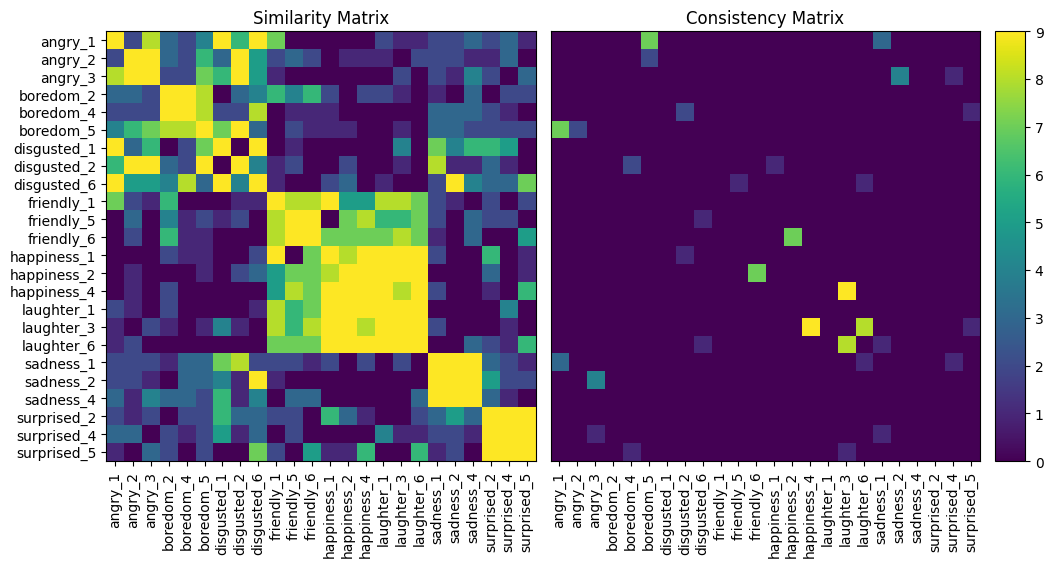

In [8]:
display_similarity_consistency_matrices(simMat, consMat, image_names)

In [9]:
def generate_random_matrix(size, e=20):
    epoch = 0
    mat = np.zeros((size, size))
    while (epoch < e):
        mat += np.random.random(size=(size, size))
        epoch += 1
    return mat / e * 10

In [10]:
def get_dissimilarity(simMat, size=size):
    dissimilarity = np.zeros(shape=(size, size))
    for i in range(size):
        for j in range(size):
            dissimilarity[i][j] = np.sqrt(abs(simMat[i][i] - 2 * simMat[i][j] + simMat[i][i])) # abs is there because errors in the random similarity matrix (many negatives)

    return dissimilarity

In [11]:
dissMat = get_dissimilarity(simMat)

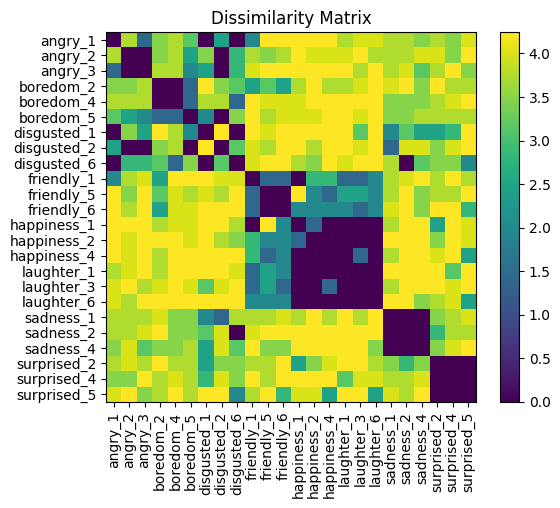

In [12]:
display_matrix(dissMat, 'Dissimilarity Matrix', image_names)

In [13]:
def pca(matrix, num_components: int = 10):
    covariance_matrix = np.cov(matrix, rowvar=False) # The variables are columns, the observations are rows (default is reversed)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort best components (higher eigenvalue means more variance explained in that eigenvector than in others)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Take the first num_components from the spectral decomposition
    eigenvectors = eigenvectors[:, :num_components]

    return eigenvalues, eigenvectors

In [14]:
def mds(dissMat, size=size):

    # 1. Compute matrix A from dissimilarity matrix, where a[i][j] = -(1/2)dissMat^2
    A = - dissMat**2 / 2

    # 2. Compute the "doubly centered" matrix B = HAH
    H = np.identity(size) - (1 / size) * np.ones(shape=(size, size))
    
    B = H * A * H

    eigval, eigvec = pca(B, 2)

    if (eigval[0] < 0 or eigval[1] < 0):
        print(eigval)
        return -1

    projection = np.dot(B, eigvec)

    return eigval[0:2], eigvec, projection

In [15]:
eigenvalues, eigenvectors, projection = mds(dissMat)
print(eigenvalues)

[4.57384136e-04 9.55376218e-05]


In [16]:
def hide_bounding_box(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

In [17]:
def show_axis(ax):
    hide_bounding_box(ax)
    ax.set_aspect(1)

    unit_circle = plt.Circle((0, 0), 1, fill=False)
    x = patches.FancyArrowPatch((0, -1.1), (0, 1.1), arrowstyle='->', mutation_scale=20)
    y = patches.FancyArrowPatch((-1.1, 0), (1.1, 0), arrowstyle='->', mutation_scale=20)

    ax.add_patch(x)
    ax.add_patch(y)
    ax.add_patch(unit_circle)

    plt.annotate(text='Arousal', xy=(0, 1.1))
    plt.annotate(text='Valence', xy=(1.1, 0))


In [18]:
def get_colormap(labels):
    colormap = []
    for label in labels:
        emotion = label.split('_')[0]
        if emotion == 'happiness':
            colormap.append('forestgreen')
        elif emotion == 'laughter':
            colormap.append('lime')
        elif emotion == 'friendly':
            colormap.append('gold')
        elif emotion == 'surprised':
            colormap.append('magenta')
        elif emotion == 'boredom':
            colormap.append('thistle')
        elif emotion == 'disgusted':
            colormap.append('tan')
        elif emotion == 'sadness':
            colormap.append('steelblue')
        elif emotion == 'angry':
            colormap.append('tomato')
    return colormap

In [19]:
def display_cma(proj, labels, title=None):
    fig, axs = plt.subplots(figsize=(8, 8))
    
    show_axis(axs)

    # Normalize, otherwise too bad
    points = np.zeros(shape=(proj.shape))
    points[:, 0] = (proj[:, 0]-min(proj[:, 0])) / (max(proj[:, 0])-min(proj[:, 0])) * 2 - 1
    points[:, 1] = (proj[:, 1]-min(proj[:, 1])) / (max(proj[:, 1])-min(proj[:, 1])) * 2 - 1

    points[:, 0] = -points[:, 0] # flip valence axis
    # points = proj

    for i, label in enumerate(labels):
        plt.annotate(text=label, xy=(points[i, 0]-0.1*np.sign(points[i, 0]), points[i, 1]+0.04*np.sign(points[i, 1])), fontsize=8, ha='center')

    colors = get_colormap(labels)

    plt.scatter(points[:, 0], points[:, 1], c=colors)

    plt.title('Circumplex Model of Affect: ' + title)
    plt.plot()

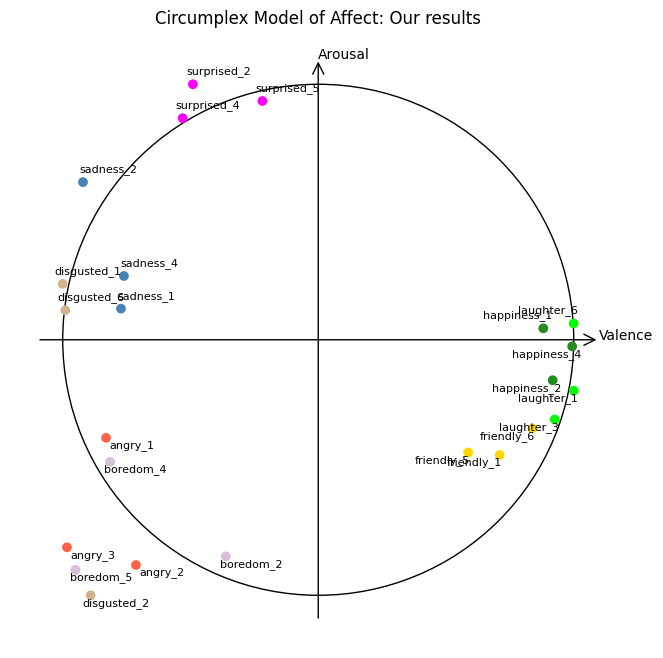

In [20]:
display_cma(projection, image_names, 'Our results')

## Random similarity matrix

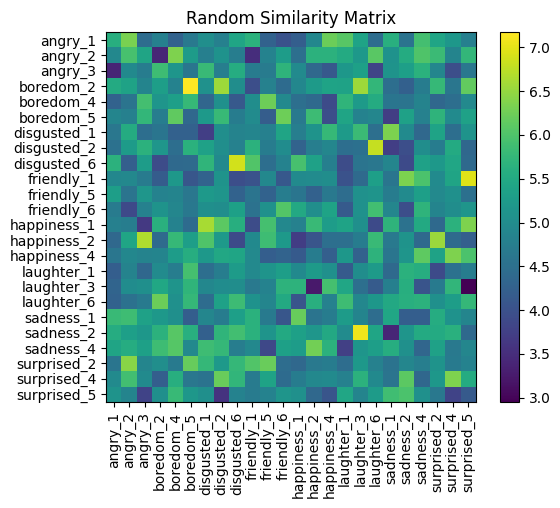

In [35]:
random_matrix = generate_random_matrix(size, e=20)
display_matrix(random_matrix, 'Random Similarity Matrix', image_names)

In [36]:
dissMatRandom = get_dissimilarity(random_matrix)

In [37]:
eigenvalues_rand, eigenvectors_rand, projection_rand = mds(dissMatRandom)

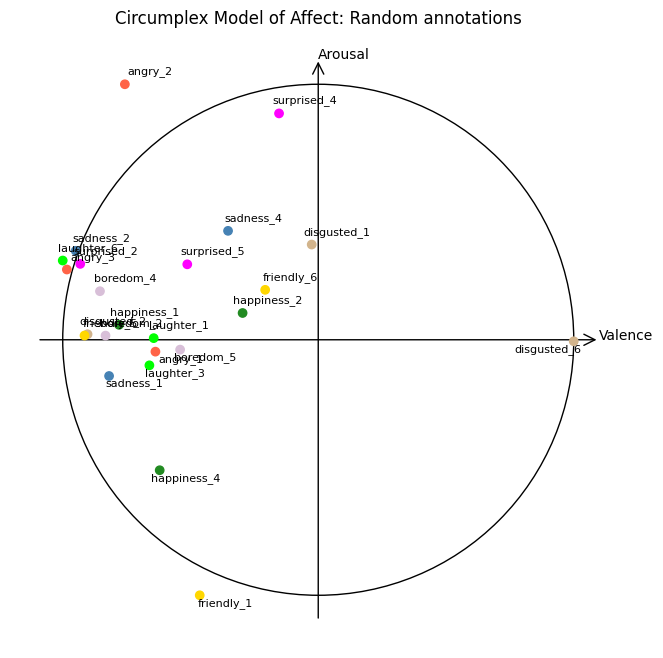

In [48]:
display_cma(projection_rand, image_names, 'Random annotations')

## Accuracy estimation

To calculate the accuracy we will generate the perfect similarity matrix and the compare it to ours and the random generated one Using MSE.

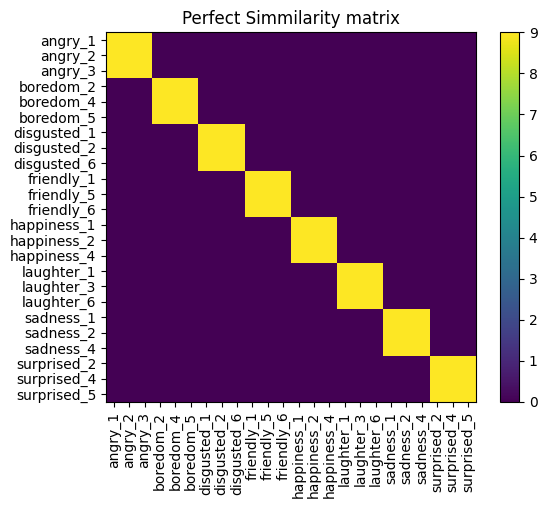

In [39]:
perfectSimm = np.zeros(shape=(size, size))

for i in range(0, size, 3):
    for j in range(0, 3):
        for k in range(0, 3):
            perfectSimm[i+j][i+k] = 9

display_matrix(perfectSimm, 'Perfect Simmilarity matrix', image_names)

In [40]:
def mse(A, B):
    return ((A - B)**2).mean()

In [41]:
mse(perfectSimm, simMat)

12.677083333333334

In [42]:
mse(perfectSimm, random_matrix)

24.766689100002022

In [43]:
mse(simMat, random_matrix)

14.885727906926535

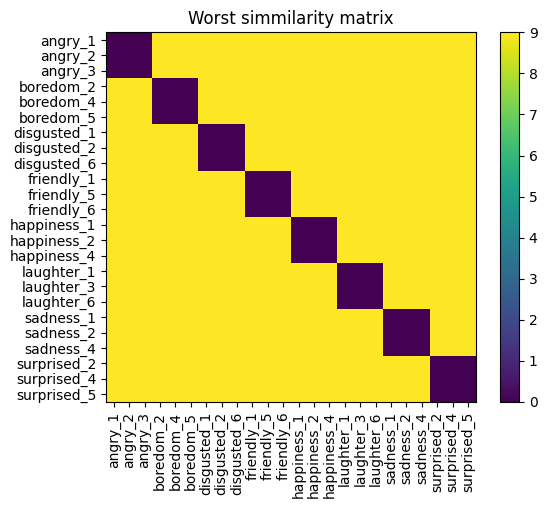

In [44]:
worstSimm = get_dissimilarity(perfectSimm)
worstSimm = worstSimm / worstSimm.max() * 9
display_matrix(worstSimm, 'Worst simmilarity matrix', image_names)

In [45]:
mse(perfectSimm, worstSimm) # the worst you can get

81.0

## How does the perfect CMA look (just hanging around)

In [46]:
p_eigenvalues, p_eigenvectors, p_proj = mds(get_dissimilarity(perfectSimm))

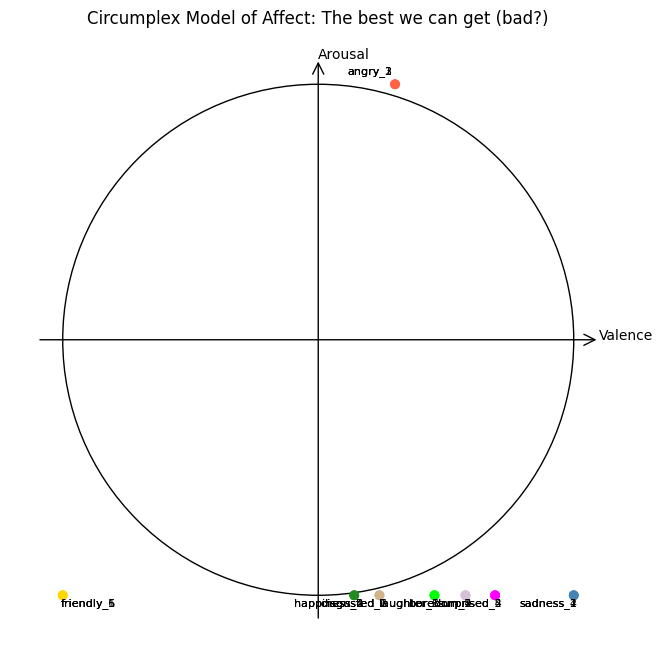

In [47]:
display_cma(p_proj, image_names, 'The best we can get (bad?)')